In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import pickle, time

# pd.set_option("display.max_columns", 100)

In [12]:
df = pd.read_pickle("../../data/total_dataset.pkl") # total dataset
#df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1) # signal and background should have the same columns
print("Total dataset number of events: ", len(df))

signal = pd.read_csv("../../data/csv/sig.csv") # as a signal, simulated data is used
print("Number of simulated signal events: ", len(signal))

bg = pd.read_pickle("../../data/psi2S.pkl")
print("Number of background events: ", len(bg))

# labels for decision trees (0 - background; 1 - signal)
vals = np.concatenate([np.zeros(len(bg)), np.ones(len(signal))])
print("Length of labels array", len(vals))

# (X - independent; Y - dependent) variables for the decision tree classifier
X = bg.append(signal) # concatenation of the two dataframes
X = X.drop(["year", "polarity", "Unnamed: 0"], axis = 1) # dropping columns that have not effect, but may have NaN or other inappropriate data
Y = vals

Total dataset number of events:  498357
Number of simulated signal events:  8802
Number of background events:  511646
Length of labels array 520448


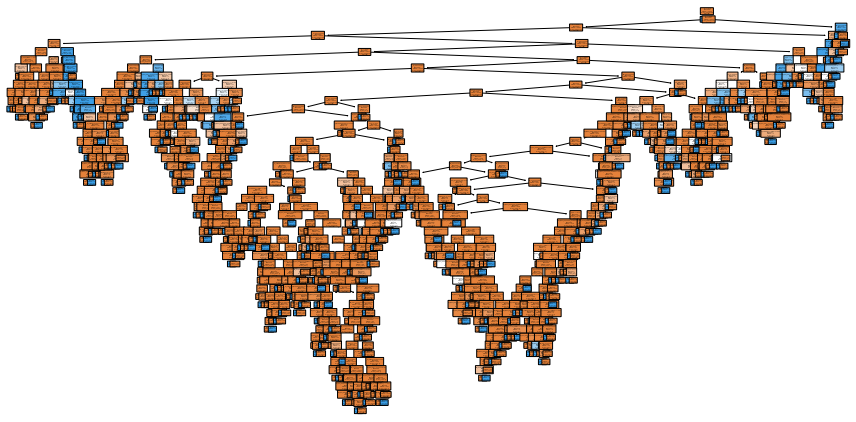

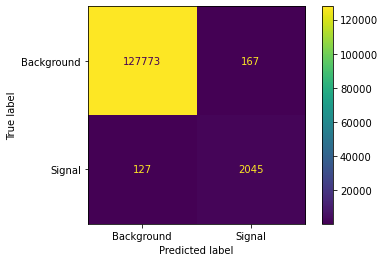

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) # splitting data into test and train samples
clf_dt = DecisionTreeClassifier() # creating a Decision Tree
clf_dt = clf_dt.fit(X_train, Y_train) # training it

# Plotting a resulting decision tree
plt.figure(figsize = (15, 7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Plotting a confusion matrix, which will check on the test data false-positive and false-negative identifications
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

<h3>Next section investigates overfitting prevention</h3>

<h3>End of investigation</h3>

In [14]:
path = clf_dt.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # last one should be removed

print(ccp_alphas)
print(len(ccp_alphas))

[0.00000000e+00 1.70779886e-06 2.32847557e-06 2.32888051e-06
 2.36396239e-06 2.40852630e-06 2.42667388e-06 2.50865928e-06
 2.51734069e-06 2.51919714e-06 2.52529689e-06 2.52631351e-06
 2.52631351e-06 2.53575360e-06 2.53810070e-06 2.54036686e-06
 2.54218851e-06 2.54368287e-06 2.54428786e-06 2.54446753e-06
 2.54446753e-06 2.54504082e-06 2.54646229e-06 2.54717186e-06
 2.54722245e-06 2.54855219e-06 2.54933708e-06 2.55011656e-06
 2.55312178e-06 2.55324034e-06 2.55427637e-06 2.55481833e-06
 2.55491475e-06 2.55513577e-06 2.55545847e-06 2.55620651e-06
 2.55642334e-06 2.55722892e-06 2.55744186e-06 2.55964219e-06
 2.55973467e-06 2.55999629e-06 2.56019568e-06 2.56035955e-06
 2.56045884e-06 2.56049315e-06 2.56055942e-06 2.56130030e-06
 2.56138782e-06 2.56142538e-06 2.56172345e-06 2.56189539e-06
 2.56189539e-06 2.56189539e-06 2.56189539e-06 2.56189539e-06
 2.56189539e-06 2.56189539e-06 2.56189539e-06 2.56189539e-06
 2.56211314e-06 2.56234568e-06 2.56421462e-06 2.56482424e-06
 2.56502402e-06 2.565738

Starting alpha num:  0
Execution time for alpha:  607.0733997821808
Starting alpha num:  1
Execution time for alpha:  609.6421117782593
Starting alpha num:  2
Execution time for alpha:  692.2534801959991
Starting alpha num:  3
Execution time for alpha:  626.1105697154999
Starting alpha num:  4
Execution time for alpha:  620.1145222187042
Starting alpha num:  5
Execution time for alpha:  615.3179132938385
Starting alpha num:  6
Execution time for alpha:  620.7648439407349
Starting alpha num:  7
Execution time for alpha:  617.2280879020691
Starting alpha num:  8
Execution time for alpha:  618.0829586982727
Starting alpha num:  9
Execution time for alpha:  618.0049741268158
Starting alpha num:  10
Execution time for alpha:  619.9778122901917
Starting alpha num:  11
Execution time for alpha:  618.1680145263672
Starting alpha num:  12
Execution time for alpha:  618.0771284103394
Starting alpha num:  13
Execution time for alpha:  617.1118457317352
Starting alpha num:  14
Execution time for a

<AxesSubplot:xlabel='alpha'>

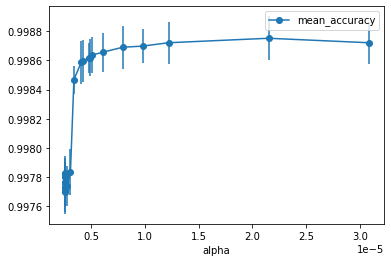

In [15]:
alpha_loop_values = []
# Check different alpha values with cross validation providing errorbars
init_time = time.time()
for num, ccp_alpha in enumerate(ccp_alphas[20::6]): # not all alphas are used to save some time - for better precision all ccp_alphas should be looked at
    print("Starting alpha num: ", num)
    start_time = time.time()
    clf_dt = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, Y_train, cv = 5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    print("Execution time for alpha: ", time.time() - start_time)
print("Total execution time: ", time.time() - init_time)
    
alpha_results = pd.DataFrame(alpha_loop_values, columns = ["alpha", "mean_accuracy", "std"])

alpha_results.plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')

<AxesSubplot:xlabel='alpha'>

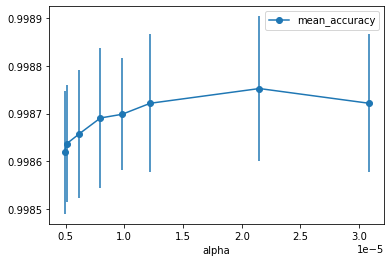

In [17]:
# find the best alpha in terms of absolute accuracy and its error
alpha_results[15:].plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')


2.080184882465567e-05


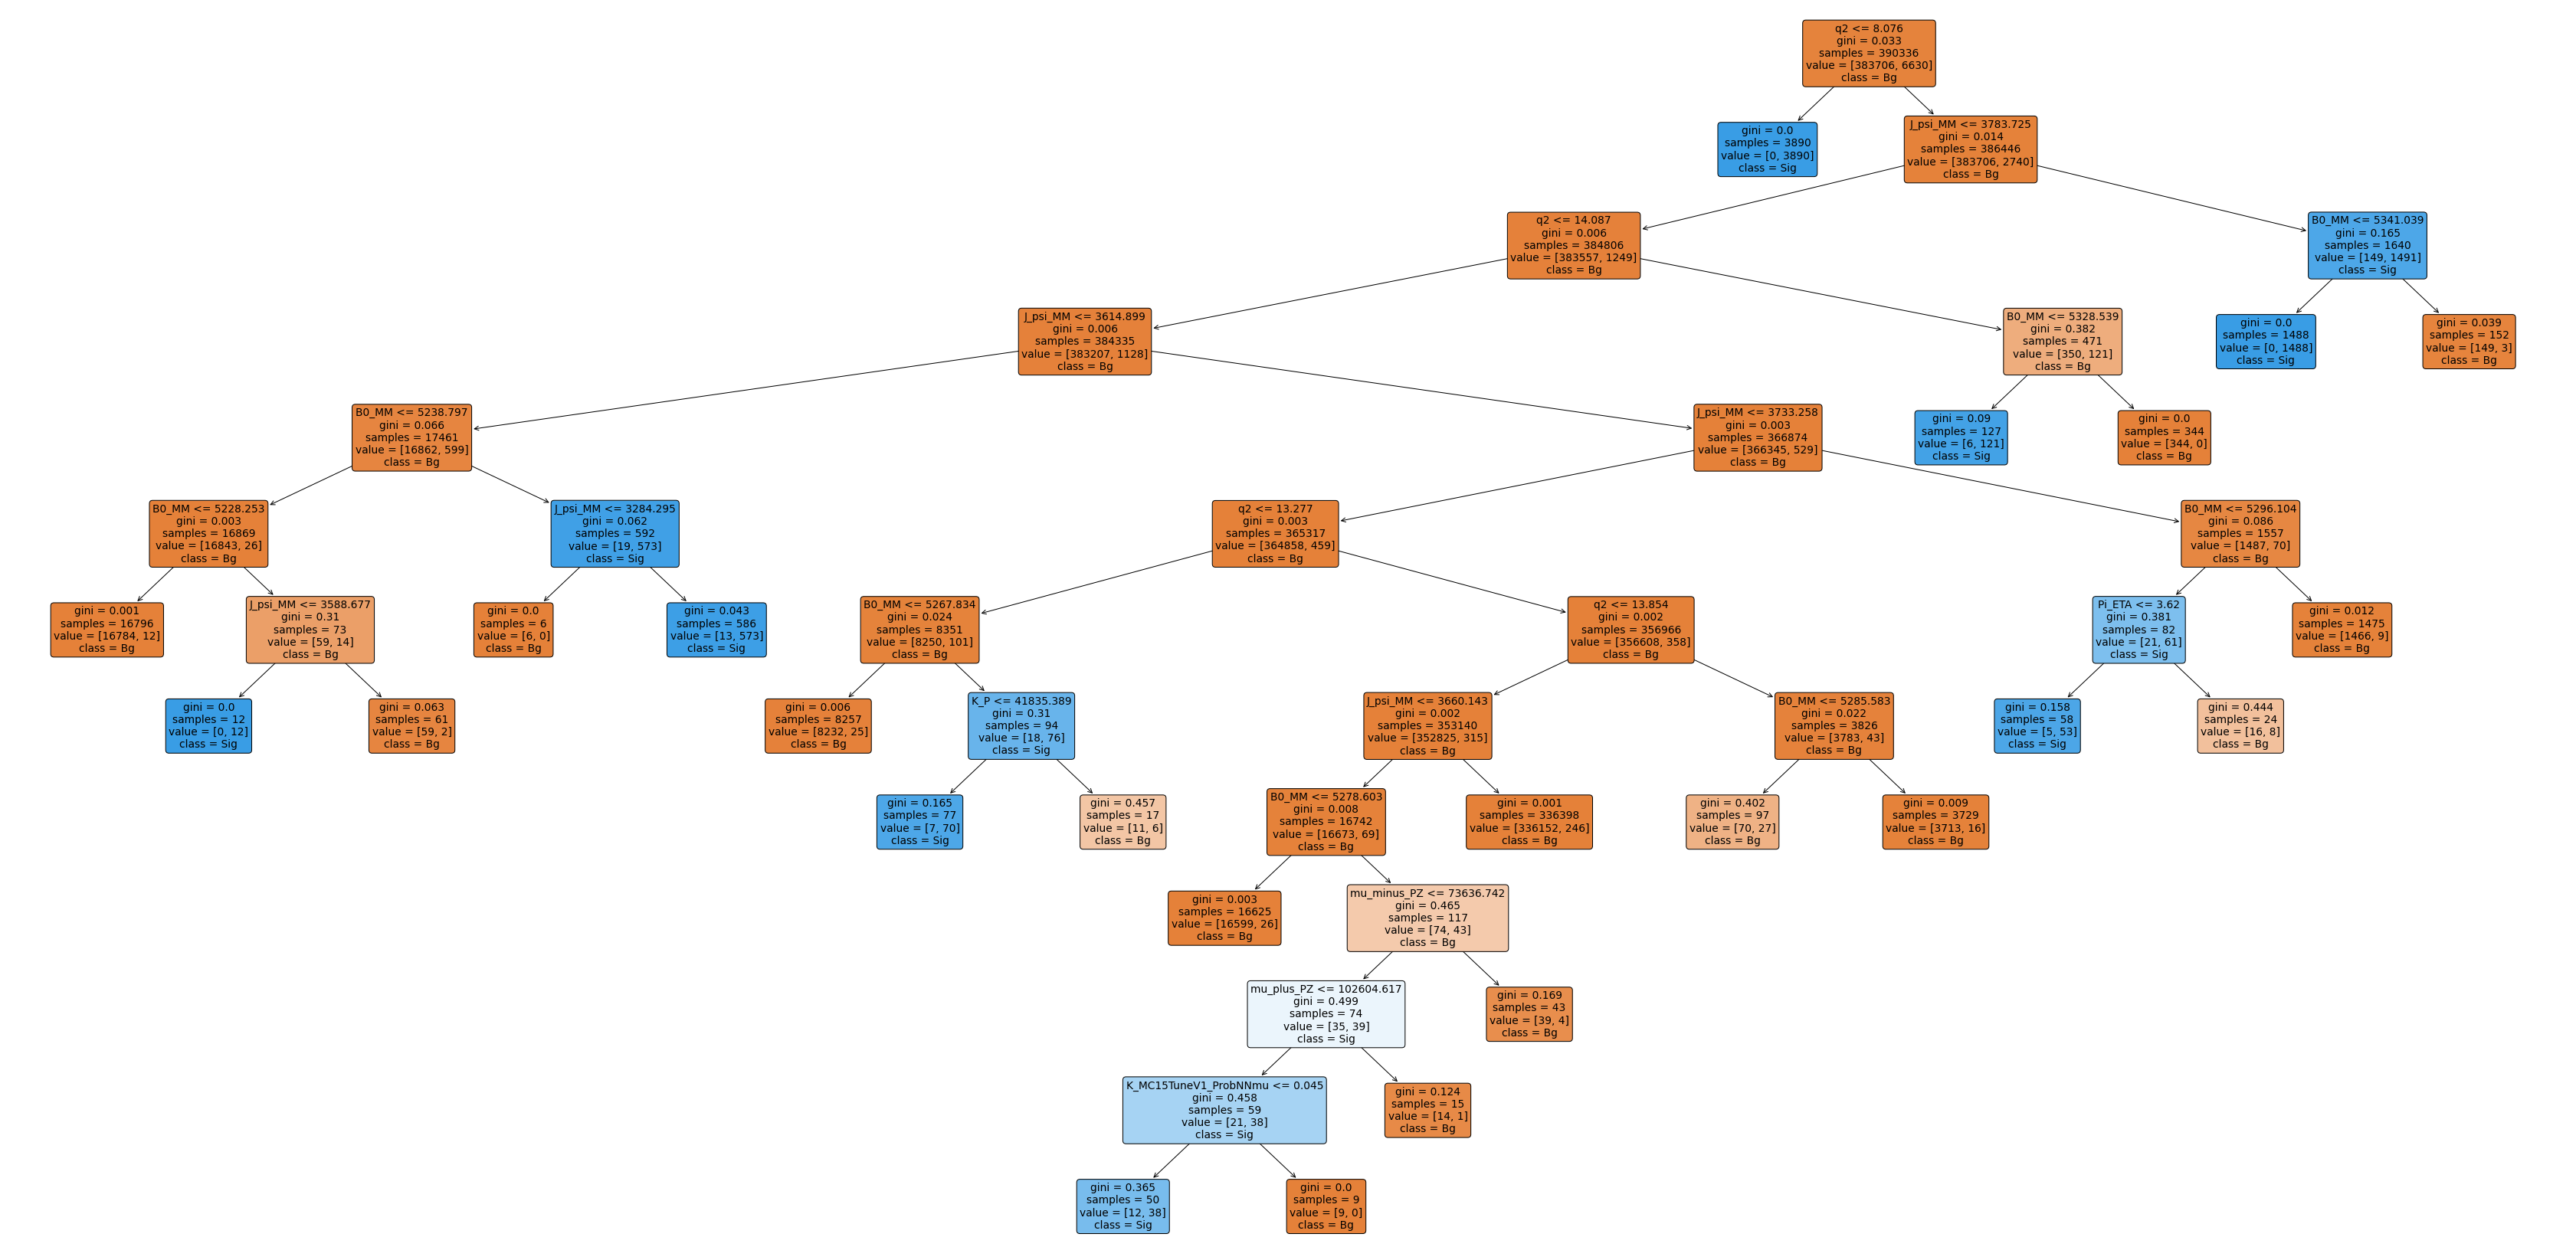

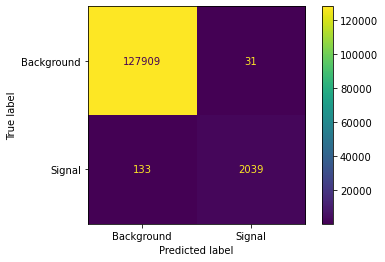

In [18]:
# Extract the best value of alpha
ideal_alpha = ccp_alphas[(ccp_alphas > 0.00002) & (ccp_alphas < 0.000025)][0]
ideal_alpha = float(ideal_alpha)
print(ideal_alpha)

# Resulting decision tree with the ccp_alpha being used to prevent overfitting
clf_dt = DecisionTreeClassifier(ccp_alpha = ideal_alpha)
clf_dt = clf_dt.fit(X_train, Y_train)

plt.figure(figsize = (60, 30))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Corresponding confusion matrix
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

In [19]:
with open("tree_psi2S", 'wb') as f: # exporting decision tree to 'tree_jpsi' binary file
    pickle.dump(clf_dt, f)

Number of bg (0) and signal (1) events identified (array([0., 1.]), array([370136, 128221], dtype=int64))


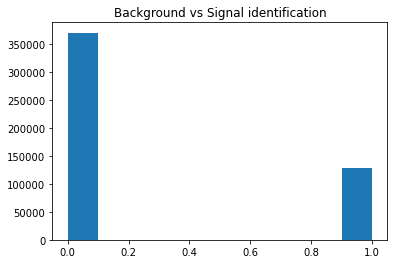

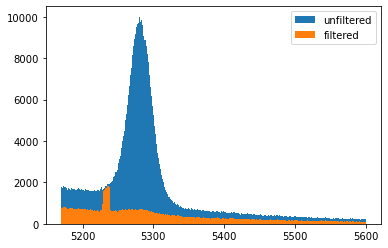

In [20]:
df = pd.read_pickle("../../data/total_dataset.pkl")
#df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1)
#print("Total number of events:", len(df))
#total_data = df[(df["B0_MM"] > min_mass) & (df["B0_MM"] < max_mass)].drop(["year", "polarity", "Unnamed: 0"], axis = 1)
#print("Number of events in the mass region", len(total_data))

# Passing data to decision tree
result = clf_dt.predict(df.drop(["year", "polarity"], axis = 1))

print("Number of bg (0) and signal (1) events identified", np.unique(result, return_counts = True))
plt.title("Background vs Signal identification")
plt.hist(result)
plt.show()

# Extracting signal data to 'Filtered_data.pkl'
df["Result"] = result
filtered = df[df["Result"] == 1]
filtered.to_pickle("Filtered_data.pkl")

# Histogram of the filtered data
plt.hist(df['B0_MM'], range=[5170, 5600], bins=300, zorder=1, label = "unfiltered")
plt.hist(filtered['B0_MM'], range=[5170, 5600], bins=300, zorder=2, label = "filtered")
plt.legend()
plt.show()